In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import seaborn as sns
import math
random.seed(36138)
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from pingouin import ancova

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer
import pingouin as pg

/Users/calvinisch/anaconda3/lib/python3.6/site-packages/distributed/config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text))
/Users/calvinisch/anaconda3/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/calvinisch/anaconda3/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
df = pd.read_csv('data/data.csv')

# Supplemental Method 1

In [3]:
df_temp = df[['ID','Optimistic1.6','Optimistic2.6','Optimistic3.6','Optimistic4.6','Optimistic5.6',
              'Optimistic6.6','Optimistic7.6','Optimistic8.6','Optimistic9.6']]
df_temp = df_temp.dropna()

days = np.log10([2,7,4*7,6*30,365,365*5,3650,36500,365000])
difs,best_time_frame,cors,means = [],[],[],[]
# for every pereson
for i in range(df_temp['ID'].count()):
    person = df_temp.iloc[[i]].loc[:, df_temp.columns != 'ID'].sum()
    # find their max and spread of optimism
    difs.append(person.max() - person.min())
    best_time_frame.append(days[list(person).index(person.min())])
    cors.append(stats.spearmanr(person,days)[0])
    means.append(person.mean())
df_temp['Peak Optimism'] = best_time_frame
df_temp['Spread'] = difs
df_temp['Cors'] = cors
df_temp['AVG'] = means

df_level = df_temp.loc[df_temp['Spread'] <= 15] # was 15
df_t = df_temp.loc[df_temp['Spread'] > 15]
df_decreasing = df_t.loc[df_t['Cors']<=-.25]
df_increasing = df_t.loc[df_t['Cors']>=.8]
df_middle = df_t.loc[(df_t['Cors']<.8) & (df_t['Cors']>-.25)]

print(df_increasing['ID'].count(),df_decreasing['ID'].count(),
     df_level['ID'].count(),df_middle['ID'].count())

/Users/calvinisch/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


119 85 64 229


In [4]:
for var in ['AVG','Cors','Spread']:
    print(var)
    df_o = df_temp[[var]].dropna()
    print(df_o[var].mean(),df_o[var].std(),stats.normaltest(df_o[var]))

print('\n')
for var in ['AVG','Cors']:
    for var_2 in ['Cors','Spread']:
        
        if var == var_2:
            next
        else:
            print(var, var_2)
            df_o = df_temp[[var,var_2]].dropna()
            print(stats.spearmanr(df_o[var],df_o[var_2]))

AVG
58.1509054325956 22.179815187456484 NormaltestResult(statistic=9.540754466887213, pvalue=0.008477181680267114)
Cors
0.28323581056314884 0.5945443259680578 NormaltestResult(statistic=86.08126954020273, pvalue=2.0309059956898675e-19)
Spread
52.18712273641851 27.72094517839706 NormaltestResult(statistic=48.25875743903581, pvalue=3.316988534649043e-11)


AVG Cors
SpearmanrResult(correlation=0.15064311929644772, pvalue=0.0009538673287464574)
AVG Spread
SpearmanrResult(correlation=-0.26174761311735584, pvalue=3.13882137035133e-09)
Cors Spread
SpearmanrResult(correlation=0.018971434599167836, pvalue=0.6790735071536391)


# Figure S2 - Groups with level optimism

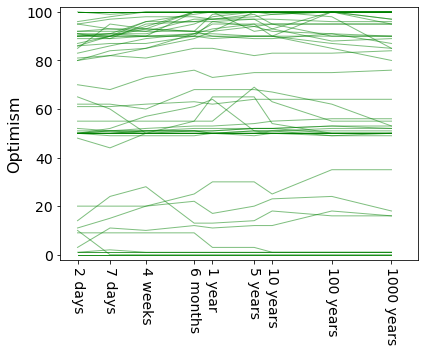

In [5]:
fig, axs = plt.subplots(1,1,figsize=(6,5))

for i in range(df_level['ID'].count()):
    person = df_level.iloc[[i]].loc[:, df_level.columns != 'ID'].sum()
    axs.plot(days,person[:9],'-',color='green',linewidth=1, alpha=.5)
 
axs.set_ylim(-2,102)
axs.set_xlim(0,6)
axs.set_xticks(days)
axs.set_yticklabels([0,0,20,40,60,80,100],fontsize=14)
axs.set_xticklabels(['2 days', '7 days', '4 weeks', '6 months', '1 year', '5 years', '10 years', '100 years',  '1000 years'],rotation=-90,fontsize=14)
axs.set_ylabel("Optimism",fontsize=16)
fig.set_tight_layout(True)
plt.savefig('SI-plots/S2_groups_of_level_optimism')
plt.show()

# Table S1

In [6]:
df_ocs = df_temp.copy()

df_factor = df.copy()

df_life_exp = pd.read_csv('External_data/US_A-Life-expectancy-CDC.csv') # from CDC USALEEP
df_life_exp = df_life_exp[['Tract ID','e(0)']]

df_inequality = pd.read_excel('External_data/Income_Inequality_by-county.xlsx') # From EPI: 
df_inequality = df_inequality[['County','Top-to-bottom ratio']]

df_income = pd.read_csv('External_data/ACSST5Y2019.S1903_data_with_overlays_2021-07-01T154811.csv') # American community survey 5-year family
df_income = df_income[['id','Geographic Area Name','Estimate!!Median income (dollars)!!FAMILIES!!Families']]


# ==================================== COUNTY LEVEL LIFE EXPECTANCY =========================================== #

df_zip_tract = pd.read_excel('External_data/ZIP_TRACT_122020.xlsx') # https://www.huduser.gov/portal/datasets/usps_crosswalk.html

# Get all census tracts aligned with a zip code.
df_temp = df[['ID','Zip.1']].dropna()
tracts = []
for z in df_temp['Zip.1']:
    tracts.append(list(df_zip_tract[['ZIP','TRACT']].loc[df_zip_tract['ZIP'] == z]['TRACT']))
df_temp['TRACTS'] = tracts

# Return average life expectancy for those.
life_exps = []
for i in df_temp['TRACTS']:
    df_t = df_life_exp.loc[df_life_exp['Tract ID'].isin(i)]
    life_exps.append(df_t['e(0)'].mean())
df_temp['County LE'] = life_exps    
df_factor= df_factor.merge(df_temp[['ID','County LE']], how='left',on='ID')

# ==================================== COUNTY LEVEL Median Income  =========================================== #

# Connect all Zip Codes to a county
df_zip_county = pd.read_excel('External_data/ZIP_COUNTY_122020.xlsx') # https://www.huduser.gov/portal/datasets/usps_crosswalk.html
df_temp = df[['ID','Zip.1']].dropna()
df_temp['ZIP'] = pd.to_numeric(df_temp['Zip.1'])
df_temp = df_temp[['ID','ZIP']].merge(df_zip_county[['ZIP','COUNTY']])

# Return County level income information
df_income['COUNTY'] = df_income['id'].apply(lambda x: int(str(x)[len(str(x))-5:]))
df_income['Median Family Income'] = df_income['Estimate!!Median income (dollars)!!FAMILIES!!Families']
df_temp = df_temp.merge(df_income[['COUNTY','Median Family Income']])
df_temp = df_temp.drop_duplicates(subset=['ID'])
df_factor= df_factor.merge(df_temp[['ID','Median Family Income']], how='left',on='ID')


# ==================================== COUNTY LEVEL Inequality =========================================== #
df_temp = df[['ID','Zip.1']].dropna()
df_temp['ZIP'] = pd.to_numeric(df_temp['Zip.1'])
df_temp = df_temp[['ID','ZIP']].merge(df_zip_county[['ZIP','COUNTY']])
df_temp = df_temp.merge(df_income[['COUNTY','Geographic Area Name']])

us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','American Samoa': 'AS','Arizona': 'AZ','Arkansas': 'AR',
    'California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Guam': 'GU','Hawaii': 'HI','Idaho': 'ID',
    'Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY',
    'Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI',
    'Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE',
    'Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH','Oklahoma': 'OK',
    'Oregon': 'OR','Pennsylvania': 'PA','Puerto Rico': 'PR','Rhode Island': 'RI','South Carolina': 'SC',
    'South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT',
    'Virgin Islands': 'VI','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'
}

def rename_bad_label(label):
    s = ""
    
    try:
        # Get state and turn into 2 letter abbreviation
        state = label[label.index(',')+2:]
        state = us_state_abbrev[str(state)]
        
        # remove county label
        county = label[:label.index(',')-7]
        s = county + ', ' + state
    except:
        s = None
    return s

df_temp['County'] = df_temp['Geographic Area Name'].apply(lambda x: rename_bad_label(x))
df_temp = df_temp[['ID','County']].merge(df_inequality[['County','Top-to-bottom ratio']],how='left',on='County').drop_duplicates(subset='ID')
df_factor= df_factor.merge(df_temp[['ID','Top-to-bottom ratio']], how='left',on='ID')
df_external = df_factor.copy()

In [7]:


names = []
rs = [[],[],[]]
vs = ['AVG','Cors','Spread']
for var_1 in ['LifeOrientation.10','CFC.Future.5','CFC.Immediate.5','b5_conscientious','b5_negemotion', 'b5_agreeable','b5_extroversion','SoPA.9','SoNA.9',
              'Age.1','Education.1','Wealth.6']:
    names.append(var_1)
    for v in range(len(vs)):
        var_2 = vs[v]
        df_temp = df[['ID',var_1]].merge(df_ocs[['ID',var_2]],how="left",on='ID').dropna()
        fix_bad_names = []
        for a in df_temp[var_1]:
            if a == ' ':
                fix_bad_names.append(None)
            else:
                fix_bad_names.append(float(a))
        df_temp[var_1] = fix_bad_names
        df_temp = df_temp.dropna()
        r = stats.spearmanr(df_temp[var_1],df_temp[var_2])
        print(var_1,var_2,'N:',df_temp[var_1].count(),'R:',round(r[0],3),'P:',round(r[1],3))
        rs[v].append(str(round(r[0],2))+' ('+str(round(r[1],3))+')')
        
        
for v in range(len(vs)):
    var_2 = vs[v]
    df_temp = df[['ID','Sex.1']].merge(df_ocs[['ID',var_2]],how="left",on='ID').dropna()
    r = stats.mannwhitneyu(df_temp.loc[df_temp['Sex.1'] == 1][var_2],df_temp.loc[df_temp['Sex.1'] == 2][var_2])
    print('Sex.1',var_2,'N:',df_temp['Sex.1'].count(),'U:',round(r[0],3),'P:',round(r[1],3))
    print(df_temp.loc[df_temp['Sex.1'] == 1][var_2].median(),df_temp.loc[df_temp['Sex.1'] == 2][var_2].median())
    rs[v].append(str(round(r[0],2))+' ('+str(round(r[1],3))+')')
names.append('Sex')
print('Males = ',df_temp.loc[df_temp['Sex.1'] == 1][var_2].count())



for var_1 in ['County LE','Median Family Income','Top-to-bottom ratio']:
    for v in range(3):
        var_2 = vs[v]
        df_temp = df_factor[['ID',var_1]].merge(df_ocs[['ID',var_2]],how="left",on='ID').dropna()
        r = stats.spearmanr(df_temp[var_1],df_temp[var_2])
        print(var_1,var_2,'N:',df_temp[var_1].count(),'R:',round(r[0],3),'P:',round(r[1],3))
        rs[v].append(str(round(r[0],2))+' ('+str(round(r[1],3))+')')

names = names + ['County LE','Median Family Income','Top-to-bottom ratio']

df_temp = pd.DataFrame({'Names:':names,'Means':rs[0],'Cor':rs[1],'Range':rs[2]})
df_temp.to_csv('SI-tables/TableS1_Curve_futures.csv')

LifeOrientation.10 AVG N: 357 R: 0.493 P: 0.0
LifeOrientation.10 Cors N: 345 R: 0.136 P: 0.011
LifeOrientation.10 Spread N: 357 R: -0.063 P: 0.238
CFC.Future.5 AVG N: 447 R: 0.054 P: 0.254
CFC.Future.5 Cors N: 430 R: 0.043 P: 0.375
CFC.Future.5 Spread N: 447 R: 0.027 P: 0.569
CFC.Immediate.5 AVG N: 449 R: -0.036 P: 0.449
CFC.Immediate.5 Cors N: 432 R: -0.021 P: 0.667
CFC.Immediate.5 Spread N: 449 R: 0.016 P: 0.741
b5_conscientious AVG N: 496 R: 0.185 P: 0.0
b5_conscientious Cors N: 477 R: 0.052 P: 0.255
b5_conscientious Spread N: 496 R: 0.016 P: 0.718
b5_negemotion AVG N: 496 R: -0.382 P: 0.0
b5_negemotion Cors N: 477 R: -0.037 P: 0.421
b5_negemotion Spread N: 496 R: 0.08 P: 0.075
b5_agreeable AVG N: 496 R: 0.149 P: 0.001
b5_agreeable Cors N: 477 R: 0.092 P: 0.044
b5_agreeable Spread N: 496 R: 0.092 P: 0.042
b5_extroversion AVG N: 496 R: 0.242 P: 0.0
b5_extroversion Cors N: 477 R: 0.068 P: 0.136
b5_extroversion Spread N: 496 R: -0.061 P: 0.172
SoPA.9 AVG N: 365 R: 0.278 P: 0.0
SoPA.9 C

# Table S2

In [8]:
level,increase,decrease,middle,ps,var_s = [],[],[],[],[],[]
for var in ['Spread','Cors','AVG']:
    level.append(round(df_level[var].median(),2))
    increase.append(round(df_increasing[var].median(),2))
    decrease.append(round(df_decreasing[var].median(),2))
    middle.append(round(df_middle[var].median(),2))
    print(var,'Level:',round(df_level[var].median(),2),' - Increase:',round(df_increasing[var].median(),2),
         ' - Decrease:',round(df_decreasing[var].median(),2),' - Middle:',round(df_middle[var].median(),2))
    print(stats.kruskal(df_level[var].dropna(),df_increasing[var].dropna(),df_decreasing[var].dropna(),df_middle[var].dropna()))
    ps.append(stats.kruskal(df_level[var].dropna(),df_increasing[var].dropna(),df_decreasing[var].dropna(),df_middle[var].dropna())[1])
    var_s.append(var)
    
def fix_em(x):
    if x == ' ':
        return(None)
    else:
        return(float(x))
    


    
for var in ['LifeOrientation.10','CFC.Future.5','CFC.Immediate.5','b5_conscientious','b5_negemotion',
              'b5_agreeable','b5_extroversion','SoPA.9','SoNA.9','Age.1','Education.1','Wealth.6']:
    df_l = df_level[['ID']].merge(df[['ID',var]],how="left",on='ID').dropna()
    df_i = df_increasing[['ID']].merge(df[['ID',var]],how="left",on='ID').dropna()
    df_d = df_decreasing[['ID']].merge(df[['ID',var]],how="left",on='ID').dropna()
    df_m = df_level[['ID']].merge(df[['ID',var]],how="left",on='ID').dropna()
    
    df_l[var] = df_l[var].apply(lambda x: fix_em(x)).dropna()
    df_i[var] = df_i[var].apply(lambda x: fix_em(x)).dropna()
    df_d[var] = df_d[var].apply(lambda x: fix_em(x)).dropna()
    df_m[var] = df_m[var].apply(lambda x: fix_em(x)).dropna()
    
    level.append(round(df_l[var].median(),2))
    increase.append(round(df_i[var].median(),2))
    decrease.append(round(df_d[var].median(),2))
    middle.append(round(df_l[var].median(),2))
    print(var,'Level:',round(df_l[var].median(),2),' - Increase:',round(df_i[var].median(),2),
         ' - Decrease:',round(df_d[var].median(),2),' - Middle:',round(df_l[var].median(),2))
    print(stats.kruskal(df_l[var].dropna(),df_i[var].dropna(),df_d[var].dropna(),df_l[var].dropna()))
    ps.append(stats.kruskal(df_l[var].dropna(),df_i[var].dropna(),df_d[var].dropna(),df_l[var].dropna())[1])
    var_s.append(var)
    
var_s.append('Sex.1')
ps.append("None")
df_l = df_level[['ID']].merge(df[['ID','Sex.1']],how="left",on='ID').dropna()
df_i = df_increasing[['ID']].merge(df[['ID','Sex.1']],how="left",on='ID').dropna()
df_d = df_decreasing[['ID']].merge(df[['ID','Sex.1']],how="left",on='ID').dropna()
df_m = df_level[['ID']].merge(df[['ID','Sex.1']],how="left",on='ID').dropna()
    
print(round(df_l.loc[df_l['Sex.1']==1]['Sex.1'].count()/df_l['Sex.1'].count(),2),
round(df_i.loc[df_i['Sex.1']==1]['Sex.1'].count()/df_i['Sex.1'].count(),2),
round(df_d.loc[df_d['Sex.1']==1]['Sex.1'].count()/df_d['Sex.1'].count(),2),
round(df_m.loc[df_m['Sex.1']==1]['Sex.1'].count()/df_m['Sex.1'].count(),2))

level.append(df_l.loc[df_l['Sex.1']==1]['Sex.1'].count()/df_l['Sex.1'].count())
increase.append(df_i.loc[df_i['Sex.1']==1]['Sex.1'].count()/df_i['Sex.1'].count())
decrease.append(df_d.loc[df_d['Sex.1']==1]['Sex.1'].count()/df_d['Sex.1'].count())
middle.append(df_m.loc[df_m['Sex.1']==1]['Sex.1'].count()/df_m['Sex.1'].count())


for var in ['County LE','Median Family Income','Top-to-bottom ratio']:
    df_l = df_level[['ID']].merge(df_factor[['ID',var]],how="left",on='ID').dropna()
    df_i = df_increasing[['ID']].merge(df_factor[['ID',var]],how="left",on='ID').dropna()
    df_d = df_decreasing[['ID']].merge(df_factor[['ID',var]],how="left",on='ID').dropna()
    df_m = df_level[['ID']].merge(df_factor[['ID',var]],how="left",on='ID').dropna()
    
    level.append(round(df_l[var].median(),2))
    increase.append(round(df_i[var].median(),2))
    decrease.append(round(df_d[var].median(),2))
    middle.append(round(df_l[var].median(),2))
    print(var,'Level:',round(df_l[var].median(),2),' - Increase:',round(df_i[var].median(),2),
         ' - Decrease:',round(df_d[var].median(),2),' - Middle:',round(df_l[var].median(),2))
    print(stats.kruskal(df_l[var].dropna(),df_i[var].dropna(),df_d[var].dropna(),df_l[var].dropna()))
    ps.append(stats.kruskal(df_l[var].dropna(),df_i[var].dropna(),df_d[var].dropna(),df_l[var].dropna())[1])
    var_s.append(var)
    
df_temp = pd.DataFrame({'Names:':var_s,'Ps':ps,'Level':level,'Increasing':increase,'Decrease':decrease,'Middle':middle})
df_temp.to_csv('SI-tables/TableS2_Types_of_curves.csv')



Spread Level: 4.0  - Increase: 55.0  - Decrease: 50.0  - Middle: 60.0
KruskalResult(statistic=168.6590443609011, pvalue=2.4782847266504336e-36)
Cors Level: 0.47  - Increase: 0.96  - Decrease: -0.68  - Middle: 0.27
KruskalResult(statistic=366.7873751858932, pvalue=3.455094725198878e-79)
AVG Level: 85.67  - Increase: 63.89  - Decrease: 54.89  - Middle: 56.67
KruskalResult(statistic=22.947261052738444, pvalue=4.1418178627117386e-05)
LifeOrientation.10 Level: 11.5  - Increase: 11.5  - Decrease: 9.0  - Middle: 11.5
KruskalResult(statistic=7.883136814996246, pvalue=0.048489678283720396)
CFC.Future.5 Level: 35.0  - Increase: 39.0  - Decrease: 37.0  - Middle: 35.0
KruskalResult(statistic=2.9194651705883383, pvalue=0.4042094583594089)
CFC.Immediate.5 Level: 25.0  - Increase: 23.0  - Decrease: 24.5  - Middle: 25.0
KruskalResult(statistic=1.3241110022754403, pvalue=0.7234157984789542)
b5_conscientious Level: 3.88  - Increase: 4.0  - Decrease: 3.75  - Middle: 3.88
KruskalResult(statistic=1.6803110

# Supplemental Method 2

In [9]:
df = pd.read_csv('data/Concreteness.csv',sep='\t')

df_concrete = pd.read_excel('External_data/13428_2013_403_MOESM1_ESM.xlsx')# concreteness 40,000 https://doi.org/10.3758/s13428-013-0403-5
concrete_dict = df_concrete.set_index('Word').to_dict()['Conc.M']

# NLTK Stopwords: https://gist.github.com/sebleier/554280
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
     "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself",
     "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which",
     "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be",
     "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an",
     "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for",
     "with", "about", "against", "between", "into", "through", "during", "before", "after", 
     "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
     "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both",
     "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", 
     "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"] 

# Calculate mean concreteness for a list of strings using this data set
def concrete_score(los):
    c = []
    if len(los) == 0:
        return(None)
    for s in los:
        if s in concrete_dict.keys():
            c.append(concrete_dict[s])
        else:
            next
    if len(c) == 0:
        return(None)
    return(sum(c)/len(c))

# remove punctuation, lower case, tokenize, remove stopwords
def make_pretty(string):
    
    # If NA return none
    if type(string) != str:
        return([])
    
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for t in string:
        if t in punc:
            string = string.replace(t, "")
    
    new = string.lower().split()
    new_new = []
    for word in new:
        if word in stop_words:
            next
        else:
            new_new.append(word)
    return(new_new)

descriptions = ['Optimism7days.6','Optimism6months.6','Optimism10years.6']
df_temp = df[['ID'] + descriptions].dropna()
for i in descriptions:
    df_temp[i] = [make_pretty(x) for x in list(df_temp[i])]
    df_temp[i] = df_temp[i].apply(lambda x: concrete_score(x))
    
print("N =",df_temp[['Optimism7days.6','Optimism6months.6','Optimism10years.6']].dropna()['Optimism6months.6'].count())
for i in descriptions:
    print(i,df_temp[i].dropna().median())

df_t = df_temp[['Optimism7days.6','Optimism6months.6','Optimism10years.6']].dropna()
print('Optimism7days.6',stats.wilcoxon(df_t['Optimism7days.6'],df_t['Optimism6months.6']))
print('Optimism7days.6',stats.wilcoxon(df_t['Optimism7days.6'],df_t['Optimism10years.6']))
print('Optimism7days.6',stats.wilcoxon(df_t['Optimism6months.6'],df_t['Optimism10years.6']))


df_t = df_temp.merge(df[['ID','Optimistic2.6','Optimistic4.6','Optimistic7.6']],how='left',on='ID')
df_tt = df_t[['Optimism7days.6','Optimistic2.6']].dropna()
print('7 Days - ',stats.spearmanr(df_tt['Optimism7days.6'],df_tt['Optimistic2.6']))

df_tt = df_t[['Optimism6months.6','Optimistic4.6']].dropna()
print('6 months - ',stats.spearmanr(df_tt['Optimism6months.6'],df_tt['Optimistic4.6']))

df_tt = df_t[['Optimism10years.6','Optimistic7.6']].dropna()
print('10 years -',stats.spearmanr(df_tt['Optimism10years.6'],df_tt['Optimistic7.6']))





N = 453
Optimism7days.6 2.8637500000000005
Optimism6months.6 2.8635
Optimism10years.6 2.69
Optimism7days.6 WilcoxonResult(statistic=39262.5, pvalue=0.5950635843297913)
Optimism7days.6 WilcoxonResult(statistic=34196.0, pvalue=3.4914438792359895e-06)
Optimism7days.6 WilcoxonResult(statistic=32122.5, pvalue=6.110368676446569e-07)
7 Days -  SpearmanrResult(correlation=0.009235801036935611, pvalue=0.8400551069088485)
6 months -  SpearmanrResult(correlation=0.05809889044919865, pvalue=0.20433179463744708)
10 years - SpearmanrResult(correlation=0.0349224574371125, pvalue=0.44052766572223634)


# Figure S3

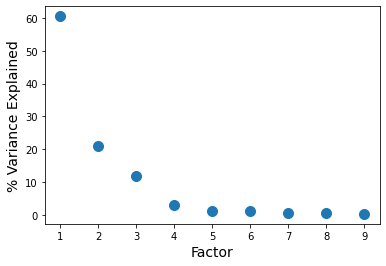

60.50019351947271
20.879463250632963
11.964127434030875
Alpha 1: (0.9432699306191851, array([0.937, 0.949])) Alpha 2: (0.938170178237306, array([0.931, 0.945])) Alpha 3: (0.93138183923881, array([0.922, 0.94 ]))


/Users/calvinisch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/calvinisch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/calvinisch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

,Var,Factor1,Factor2,Factor3
0,2 days,0.933032,0.147033,0.119675
1,7 days,0.971176,0.179297,0.104580
2,4 weeks,0.894127,0.313931,0.108168
3,6 months,0.686528,0.634749,0.060178
4,1 year,0.426846,0.814620,0.111339
5,5 years,0.187977,0.921585,0.272452
6,10 years,0.144589,0.814401,0.386426
7,100 years,0.116408,0.319182,0.899688
8,1000 years,0.106809,0.154444,0.899808


In [10]:
df = pd.read_csv('data/data.csv')

# Create Factors =========================================

df_temp = df[['Optimistic1.6','Optimistic2.6','Optimistic3.6','Optimistic4.6','Optimistic5.6',
              'Optimistic6.6','Optimistic7.6','Optimistic8.6','Optimistic9.6']]
x = df_temp.dropna()
fa = FactorAnalyzer()
fa.fit(x, 9)

#Get Eigen values and plot them
ev, v = fa.get_eigenvalues()
plt.plot(range(1,x.shape[1]+1),[i/9*100 for i in ev],'o',ms=10)
plt.ylabel("% Variance Explained",fontsize=14)
plt.xlabel("Factor",fontsize=14)
fig.set_tight_layout(True)
plt.savefig('SI-plots/S3_Factor_Analysis_variance.png')
plt.show()
[print(i/9*100) for i in ev[:3]]

fa = FactorAnalyzer(3, rotation='varimax')
fa.fit(x)
loads = fa.loadings_

# Loading factor of .65 splits into these groups
# Factor 1 = '2 days', '7 days', '4 weeks', '6 months'
# Factor 2 = '1 year', '5 years', '10 years'
# Factor 3 = '100 years',  '1000 years'
# Near, medium, and distant future


#Create the factors
factor1 = df[['Optimistic1.6','Optimistic2.6','Optimistic3.6','Optimistic4.6','Optimistic5.6']]
factor2 = df[['Optimistic6.6','Optimistic7.6','Optimistic5.6']]
factor3 = df[['Optimistic8.6','Optimistic9.6']]
#Get cronbach alpha
factor1_alpha = pg.cronbach_alpha(factor1)
factor2_alpha = pg.cronbach_alpha(factor2)
factor3_alpha = pg.cronbach_alpha(factor3)
print("Alpha 1:",factor1_alpha, "Alpha 2:",factor2_alpha, "Alpha 3:", factor3_alpha)
new_variables = fa.fit_transform(x)

df_t = df[['ID','Optimistic1.6','Optimistic2.6','Optimistic3.6','Optimistic4.6','Optimistic5.6',
              'Optimistic6.6','Optimistic7.6','Optimistic8.6','Optimistic9.6']]
df_t = df_t.dropna()
df_temp['ID'] = df_t['ID']
df_factor = df_temp.dropna() 

df_factor['Factor1'] = new_variables[:,0]
df_factor['Factor2'] = new_variables[:,1]
df_factor['Factor3'] = new_variables[:,2]
df_factor = df_factor[['ID','Factor1','Factor2','Factor3']]



# Factor Loadings =========================================

a = ['2 days', '7 days', '4 weeks', '6 months', '1 year', '5 years', '10 years', '100 years',  '1000 years']
vals = [[],[],[],[]]
for i in range(len(a)):
    vals[0].append(a[i])
    vals[1].append(loads[i][0])
    vals[2].append(loads[i][1])
    vals[3].append(loads[i][2])
df_print = pd.DataFrame({'Var':vals[0],'Factor1':vals[1],'Factor2':vals[2],'Factor3':vals[3]})
df_print

# Figure S4

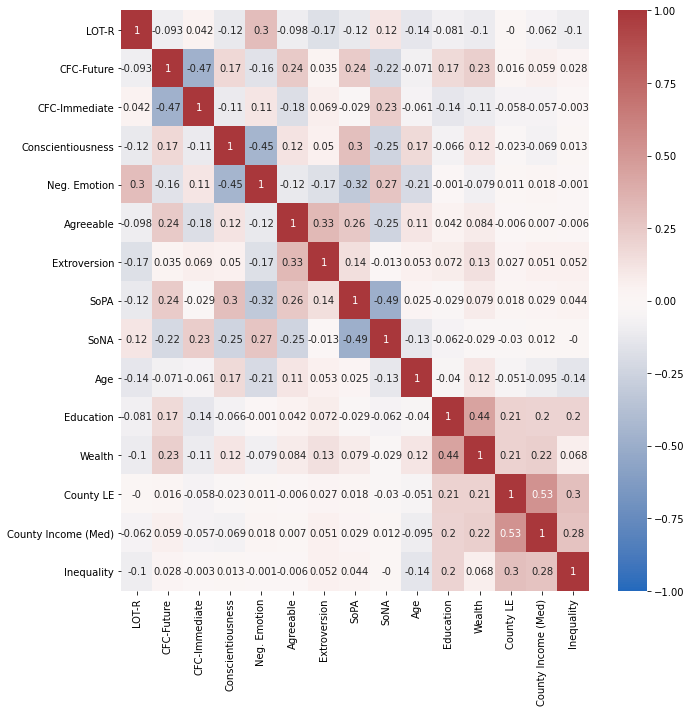

In [11]:
df_temp = df_external[['ID','County LE','Median Family Income','Top-to-bottom ratio']].merge(df,how='left',on='ID')
all_vars = ['LifeOrientation.10','CFC.Future.5','CFC.Immediate.5','b5_conscientious','b5_negemotion',
            'b5_agreeable','b5_extroversion','SoPA.9','SoNA.9','Age.1','Education.1','Wealth.6',
            'County LE','Median Family Income','Top-to-bottom ratio']
cors = [[] for i in range(len(all_vars))]

for v in range(len(all_vars)):
    var_1 = all_vars[v]
    for var_2 in all_vars:
        if var_1 == var_2:
            cors[v].append(1)
            next
        else:
            df_t = df_temp[[var_1,var_2]].dropna()
            r = stats.spearmanr(df_t[var_1],df_t[var_2])
            cors[v].append(round(r[0],3))

df_matrix = pd.DataFrame({'LOT-R':cors[0],'CFC-Future':cors[1],'CFC-Immediate':cors[2],'Conscientiousness':cors[3],"Neg. Emotion":cors[4],
                          'Agreeable':cors[5],'Extroversion':cors[6],'SoPA':cors[7],'SoNA':cors[8],'Age':cors[9],'Education':cors[10],'Wealth':cors[11],
                          'County LE':cors[12],'County Income (Med)':cors[13],'Inequality':cors[14]
                         })
df_matrix.index = ['LOT-R','CFC-Future','CFC-Immediate','Conscientiousness',"Neg. Emotion",'Agreeable','Extroversion','SoPA','SoNA',
                   'Age','Education','Wealth','County LE','County Income (Med)','Inequality']
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_matrix, annot=True,cmap='vlag',vmin=-1, vmax=1)
plt.tight_layout()
plt.savefig('SI-plots/S4_heatmap.png')
plt.show()

# Figure S5

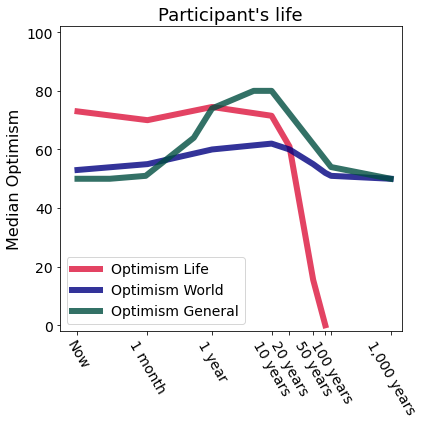

In [12]:

# First plot self
df_temp = df[['ID','PositiveRightNow1.9','PositiveLife1.9','PositiveLife2.9',
              'PositiveLife3.9','PositiveLife4.9','PositiveLife5.9','PositiveLife6.9']].dropna()
days = np.log10([2,30,365,3650,365*20,365*50,365*80])
means = [df_temp[x].median() for x in ['PositiveRightNow1.9','PositiveLife1.9','PositiveLife2.9',
              'PositiveLife3.9','PositiveLife4.9','PositiveLife5.9','PositiveLife6.9']]

fig, axs = plt.subplots(1,1,figsize=(6,6))

axs.set_ylim(-2,102)
axs.set_xlim(0,5.75)
axs.set_title("Participant's life",fontsize=18)
axs.set_yticklabels([0,0,20,40,60,80,100],fontsize=14)
axs.set_xticklabels(['Now','1 month','1 year','10 years','20 years','50 years','80 years'],rotation=-90,fontsize=14)
axs.set_ylabel("Median Optimism",fontsize=16)
axs.plot(days,means,'-',color='#dc143c',linewidth=6, label="Optimism Life",alpha=.8)

    
# Then plot the world!!!
df_temp = df[['ID','PositiveRightNow2.9','PositiveWorld1.9','PositiveWorld2.9',
              'PositiveWorld3.9','PositiveWorld4.9','PositiveWorld5.9','PositiveWorld6.9',
              'PositiveWorld8.9','PositiveWorld9.9']].dropna()
days = np.log10([2,30,365,3650,365*20,365*50,365*80,365 * 100, 365 * 1000])
means = [df_temp[x].median() for x in ['PositiveRightNow2.9','PositiveWorld1.9','PositiveWorld2.9','PositiveWorld3.9',
                                     'PositiveWorld4.9','PositiveWorld5.9','PositiveWorld6.9','PositiveWorld8.9','PositiveWorld9.9']]
axs.set_xticks(days)
axs.set_xticklabels(['Now','1 month','1 year','10 years','20 years','50 years','','100 years','1,000 years'],rotation=-60,fontsize=14)
axs.plot(days,means,'-',color='#000080',linewidth=6,label="Optimism World",alpha=.8)


# Then plot general OC
df_temp = df[['ID','Optimistic1.6','Optimistic2.6','Optimistic3.6','Optimistic4.6','Optimistic5.6',
              'Optimistic6.6','Optimistic7.6','Optimistic8.6','Optimistic9.6']]
df_temp = df_temp.dropna()

days = np.log10([2,7,4*7,6*30,365,365*5,3650,36500,365000])
axs.plot(days,[df_temp[i].median() for i in df_temp.columns[1:10]],'-',color='#004D40',linewidth=6, label="Optimism General",alpha=.8)



axs.legend(fontsize=14)
plt.tight_layout()
plt.savefig('SI-plots/S5_self-world-gen.png')
plt.show()

# Figure S6

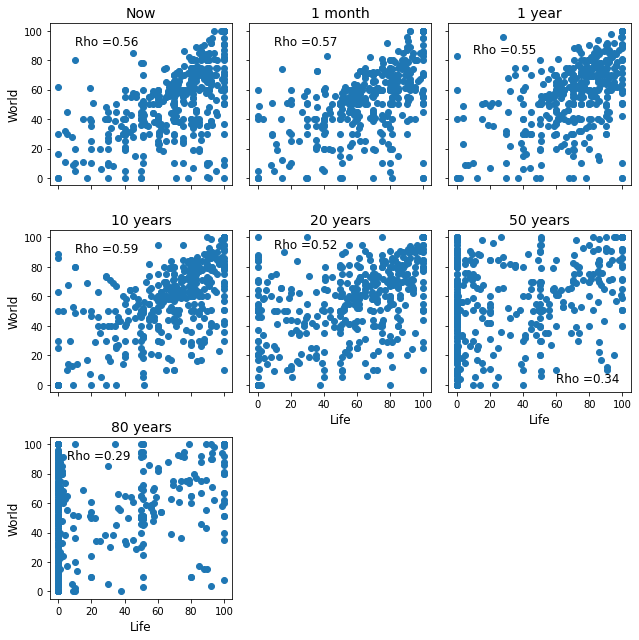

In [13]:

df_temp = df[['ID','PositiveRightNow1.9','PositiveLife1.9','PositiveLife2.9','PositiveLife3.9',
              'PositiveLife4.9','PositiveLife5.9','PositiveLife6.9','PositiveRightNow2.9',
              'PositiveWorld1.9','PositiveWorld2.9','PositiveWorld3.9','PositiveWorld4.9',
              'PositiveWorld5.9','PositiveWorld6.9']]
vars_all = [['ID','PositiveRightNow1.9','PositiveRightNow2.9'],
            ['ID','PositiveLife1.9','PositiveWorld1.9'],
            ['ID','PositiveLife2.9','PositiveWorld2.9'],
            ['ID','PositiveLife3.9','PositiveWorld3.9'],
           ['ID','PositiveLife4.9','PositiveWorld4.9'],
           ['ID','PositiveLife5.9','PositiveWorld5.9'],
           ['ID','PositiveLife6.9','PositiveWorld6.9']]
df_compare = pd.DataFrame({"User":[],'Life':[],'World':[],'TF':[]})

times = ['Now','1 month','1 year','10 years','20 years','50 years','80 years']

for v in range(len(vars_all)):
    vars_ = vars_all[v]
    df_t = df_temp[vars_].dropna()
    user = list(df_t[vars_[0]])
    life = [val for val in list(df_t[vars_[1]])]
    world = [val for val in list(df_t[vars_[2]])]
    df_c =  pd.DataFrame({"User":user,'Life':life,'World':world})
    df_c['TF'] = times[v]
    df_compare = pd.concat([df_compare,df_c])


fig, axs = plt.subplots(3,3,figsize=(9,9))


rows, cols = [0,0,0,1,1,1,2,2,2],[0,1,2,0,1,2,0,1,2]
xs = [10,10,10,10,10,60,5]
ys = [90,90,85,90,93,2,90]


for i in range(7):
    df_t = df_compare.loc[df_compare.TF == times[i]]
    axs[rows[i],cols[i]].plot(df_t['Life'],df_t['World'],'o')
    axs[rows[i],cols[i]].set_title(times[i],fontsize=14)
    axs[rows[i],cols[i]].annotate("Rho ="+str(round(stats.spearmanr(df_t['Life'],df_t['World'])[0],2)), (xs[i], ys[i]),fontsize=12)
    if (rows[i] == 2) or (cols[i] > 0 and rows[i] == 1):
        axs[rows[i],cols[i]].set_xlabel('Life',fontsize=12)
    else:
        axs[rows[i],cols[i]].set_xticklabels(["","","","","",""])
        
    if cols[i] == 0:
        axs[rows[i],cols[i]].set_ylabel('World',fontsize=12)
    else:
        axs[rows[i],cols[i]].set_yticklabels(["","","","","",""])

axs[2, 1].axis('off') 
axs[2, 2].axis('off')
plt.tight_layout()
plt.savefig("SI-plots/S6_correlations-life-world.png")
plt.show()
    

# Figure S7

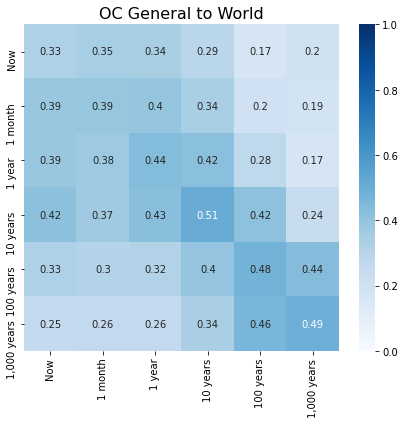

In [14]:
# Create Factors =========================================
# Life - Now, 1 month, 1 year, 10 years
# World - 
df_temp = df[['PositiveRightNow1.9','PositiveLife1.9','PositiveLife2.9',
              'PositiveLife3.9','PositiveRightNow2.9','PositiveWorld1.9','PositiveWorld2.9',
              'PositiveWorld3.9','PositiveWorld8.9','PositiveWorld9.9','Optimistic1.6',
              'Optimistic3.6','Optimistic5.6','Optimistic7.6','Optimistic8.6','Optimistic9.6']]


all_vars = ['PositiveRightNow2.9','PositiveWorld1.9','PositiveWorld2.9','PositiveWorld3.9','PositiveWorld8.9','PositiveWorld9.9']
all_vars_2 = ['Optimistic1.6','Optimistic3.6','Optimistic5.6','Optimistic7.6','Optimistic8.6','Optimistic9.6']
cors = [[] for i in range(len(all_vars))]

for v in range(len(all_vars)):
    var_1 = all_vars[v]
    for var_2 in all_vars_2:
        df_t = df_temp[[var_1,var_2]].dropna()
        r = stats.pearsonr(df_t[var_1],df_t[var_2])
        cors[v].append(round(r[0],3))

df_matrix = pd.DataFrame({'Now':cors[0],'1 month':cors[1],'1 year':cors[2],"10 years":cors[3],"100 years":cors[4],"1,000 years":cors[5]})
df_matrix.index = ['Now','1 month','1 year',"10 years",'100 years','1,000 years']

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df_matrix, annot=True,cmap='Blues',vmin=0, vmax=1)
plt.title("OC General to World",fontsize=16)
plt.tight_layout()
plt.savefig('SI-plots/S7_General-world_heatmap.png')
plt.show()


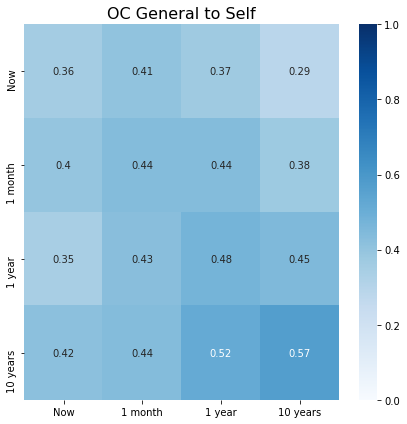

In [15]:
# Create Factors =========================================
# Life - Now, 1 month, 1 year, 10 years
# World - 
df_temp = df[['PositiveRightNow1.9','PositiveLife1.9','PositiveLife2.9',
              'PositiveLife3.9','PositiveRightNow2.9','PositiveWorld1.9','PositiveWorld2.9',
              'PositiveWorld3.9','PositiveWorld8.9','PositiveWorld9.9','Optimistic1.6',
              'Optimistic3.6','Optimistic5.6','Optimistic7.6','Optimistic8.6','Optimistic9.6']]


all_vars = ['PositiveRightNow1.9','PositiveLife1.9','PositiveLife2.9','PositiveLife3.9']
all_vars_2 = ['Optimistic1.6','Optimistic3.6','Optimistic5.6','Optimistic7.6',]
cors = [[] for i in range(len(all_vars))]

for v in range(len(all_vars)):
    var_1 = all_vars[v]
    for var_2 in all_vars_2:
        df_t = df_temp[[var_1,var_2]].dropna()
        r = stats.pearsonr(df_t[var_1],df_t[var_2])
        cors[v].append(round(r[0],3))

df_matrix = pd.DataFrame({'Now':cors[0],'1 month':cors[1],'1 year':cors[2],"10 years":cors[3]})
df_matrix.index = ['Now','1 month','1 year',"10 years"]

fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df_matrix, annot=True,cmap='Blues',vmin=0, vmax=1)
plt.title("OC General to Self",fontsize=16)
plt.tight_layout()
plt.savefig('SI-plots/S7_general-life_heatmap.png')
plt.show()


# Supplemental Table 3

In [16]:
df_temp = df_external[['ID','County LE','Median Family Income','Top-to-bottom ratio']].merge(df,how='left',on='ID')
all_vars = ['CFC.Future.5','CFC.Immediate.5','b5_conscientious','b5_negemotion','SoPA.9','SoNA.9','LifeExpectancy.7',
            'Age.1','Education.1','Income.6','County LE','Median Family Income','Top-to-bottom ratio','Sex-ratio']


all_vars = ['LifeOrientation.10','CFC.Future.5','CFC.Immediate.5','b5_conscientious','b5_negemotion',
            'b5_agreeable','b5_extroversion','SoPA.9','SoNA.9','Age.1','Education.1','Wealth.6',
            'County LE','Median Family Income','Top-to-bottom ratio']


means,medians,normals,ns=[],[],[],[]

for var in all_vars:
    
    #df_t = df_temp[['ID',var]].drop_duplicates()
    df_temp[var]= df_temp[var].apply(lambda x: fix_em(x))
    df_t = df_temp[['ID',var]].drop_duplicates()
    column = df_temp[var].dropna()
    ns.append(column.count())
    means.append(str(round(column.mean(),2))+' ('+str(round(column.std(),2))+')')
    medians.append(str(round(column.median(),2))+' ('+str(round(column.quantile(.25),2))+', '+ str(round(column.quantile(.75),2))+')')
    normal = stats.normaltest(df_temp[var].dropna())
    normals.append(str(round(normal[0],1))+' ('+str(round(normal[1],3))+')')
df_table = pd.DataFrame({'N':ns,'Means':means,'Medians':medians,'Normal':normals})

df_table.index = ['LOT-R','CFC-Future','CFC-Immediate','Conscientiousness',"Neg. Emotion",'Agreeable','Extroversion','SoPA','SoNA',
                   'Age','Education','Wealth','County LE','County Income (Med)','Inequality']
df_table.to_csv('SI-tables/TableS3_distribution-stats.csv')